In [2]:
import re
import csv

def extract_tsung_stats(log_file):
    """
    Extracts parameter-wise statistics from Tsung result.log
    Returns a list of dictionaries (one per stats dump)
    """

    data = []
    current = {}

    with open(log_file, "r") as f:
        for line in f:
            line = line.strip()

            # New stats dump
            if line.startswith("# stats: dump at"):
                if current:
                    data.append(current)
                timestamp = int(line.split()[-1])
                current = {
                    "timestamp": timestamp
                }

            # Active users
            elif line.startswith("stats: users "):
                parts = line.split()
                current["active_users"] = int(parts[2])

            # Finished users
            elif line.startswith("stats: finish_users_count"):
                parts = line.split()
                current["finished_users"] = int(parts[2])

            # Request stats (throughput + response time)
            elif line.startswith("stats: request "):
                parts = line.split()
                current["requests"] = int(parts[2])
                current["mean_rt_ms"] = float(parts[3])
                current["max_rt_ms"] = float(parts[5])

            # HTTP 200 responses
            elif line.startswith("stats: 200 "):
                parts = line.split()
                current["http_200"] = int(parts[2])

            # CPU utilization (controller)
            elif "{cpu," in line:
                parts = line.split()
                current["cpu_util_percent"] = float(parts[3])

        # Append last block
        if current:
            data.append(current)

    return data


def write_csv(data, output_file):
    """
    Writes extracted data into CSV for later plotting
    """
    if not data:
        return

    fieldnames = sorted(data[0].keys())

    with open(output_file, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for row in data:
            writer.writerow(row)


if __name__ == "__main__":
    input_log = "result.log"
    output_csv = "extracted_stats.csv"

    stats = extract_tsung_stats(input_log)
    write_csv(stats, output_csv)

    print(f"[INFO] Extracted {len(stats)} stats intervals")
    print(f"[INFO] Data written to {output_csv}")


[INFO] Extracted 60 stats intervals
[INFO] Data written to extracted_stats.csv


In [6]:
import csv
import matplotlib.pyplot as plt


def load_csv(csv_file):
    """
    Load extracted Tsung stats CSV into lists
    """
    data = {
        "users": [],
        "throughput": [],
        "mean_rt": [],
        "max_rt": [],
        "cpu": [],
        "http_200": [],
        "finished_users": []
    }

    with open(csv_file, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row.get("active_users"):
                data["users"].append(int(row["active_users"]))
                data["throughput"].append(int(row.get("requests", 0)))
                data["mean_rt"].append(float(row.get("mean_rt_ms", 0)))
                data["max_rt"].append(float(row.get("max_rt_ms", 0)))
                data["cpu"].append(float(row.get("cpu_util_percent", 0)))
                data["http_200"].append(int(row.get("http_200", 0)))
                data["finished_users"].append(int(row.get("finished_users", 0)))

    return data


def save_plot(x, y, xlabel, ylabel, title, filename):
    """
    Save a clean matplotlib plot
    """
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, marker="o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()


if __name__ == "__main__":

    csv_file = "extracted_stats.csv"
    stats = load_csv(csv_file)

    # 1. Response Time vs Number of Users
    save_plot(
        stats["users"],
        stats["mean_rt"],
        "Number of Users",
        "Mean Response Time (ms)",
        "Response Time vs Number of Users",
        "rt_vs_users.png"
    )

    # 2. Throughput vs Number of Users
    save_plot(
        stats["users"],
        stats["throughput"],
        "Number of Users",
        "Throughput (requests / interval)",
        "Throughput vs Number of Users",
        "throughput_vs_users.png"
    )

    # 3. CPU Utilization vs Number of Users
    save_plot(
        stats["users"],
        stats["cpu"],
        "Number of Users",
        "CPU Utilization (%)",
        "CPU Utilization vs Number of Users",
        "cpu_vs_users.png"
    )

    # 4. Response Time vs Throughput
    save_plot(
        stats["throughput"],
        stats["mean_rt"],
        "Throughput (requests / interval)",
        "Mean Response Time (ms)",
        "Response Time vs Throughput",
        "rt_vs_throughput.png"
    )

    # 5. Fraction of Requests Dropped vs Users
    dropped_fraction = []
    for total, ok in zip(stats["throughput"], stats["http_200"]):
        if total > 0:
            dropped_fraction.append((total - ok) / total)
        else:
            dropped_fraction.append(0)

    save_plot(
        stats["users"],
        dropped_fraction,
        "Number of Users",
        "Fraction of Requests Dropped",
        "Drop Fraction vs Number of Users",
        "drop_fraction_vs_users.png"
    )

    print("[INFO] All plots generated successfully.")


[INFO] All plots generated successfully.


In [7]:
def load_tsung_data(file_path, num_fields):
    """
    Generic loader for Tsung data/*.txt files

    Args:
        file_path: path to the file
        num_fields: expected number of numeric fields per row

    Returns:
        list of lists (floats)
    """
    data = []

    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= num_fields:
                try:
                    row = [float(x) for x in parts[:num_fields]]
                    data.append(row)
                except ValueError:
                    continue
    return data


In [8]:
def extract_from_data_dir(data_dir="data"):
    stats = {}

    # Active users
    users_data = load_tsung_data(f"{data_dir}/users.txt", 3)
    stats["time_users"] = [x[0] for x in users_data]
    stats["active_users"] = [x[1] for x in users_data]

    # User arrivals
    arrivals = load_tsung_data(f"{data_dir}/users_count.txt", 3)
    stats["time_arrival"] = [x[0] for x in arrivals]
    stats["arrival_rate"] = [x[1] for x in arrivals]

    # Finished users
    finished = load_tsung_data(f"{data_dir}/finish_users_count.txt", 3)
    stats["time_finished"] = [x[0] for x in finished]
    stats["finished_users"] = [x[2] for x in finished]

    # Throughput
    reqs = load_tsung_data(f"{data_dir}/request.txt", 3)
    stats["time_req"] = [x[0] for x in reqs]
    stats["throughput"] = [x[1] for x in reqs]

    # Response time
    rt = load_tsung_data(f"{data_dir}/tr_http_request.txt", 8)
    stats["time_rt"] = [x[0] for x in rt]
    stats["mean_rt_ms"] = [x[2] for x in rt]
    stats["max_rt_ms"] = [x[4] for x in rt]

    # HTTP 200 responses
    ok = load_tsung_data(f"{data_dir}/200.txt", 3)
    stats["time_200"] = [x[0] for x in ok]
    stats["http_200"] = [x[1] for x in ok]

    return stats


In [9]:
def derive_metrics(stats):
    derived = {}

    # Drop fraction
    derived["drop_fraction"] = []
    for total, ok in zip(stats["throughput"], stats["http_200"]):
        if total > 0:
            derived["drop_fraction"].append((total - ok) / total)
        else:
            derived["drop_fraction"].append(0)

    # Approx throughput per second (Tsung default interval = 10s)
    derived["throughput_rps"] = [x / 10.0 for x in stats["throughput"]]

    return derived


In [10]:
if __name__ == "__main__":
    stats = extract_from_data_dir(r"D:\IITB\Courses\SEM 2\CS 681\Performance-Analysis-CS681\results\20260131-1608\data")
    derived = derive_metrics(stats)

    print("[INFO] Active users:", stats["active_users"][:5])
    print("[INFO] Mean RT:", stats["mean_rt_ms"][:5])
    print("[INFO] Throughput (req/s):", derived["throughput_rps"][:5])


[INFO] Active users: [78.0, 176.0, 289.0, 378.0, 462.0]
[INFO] Mean RT: [926.9347792207794, 124.11724150943398, 1379.6669466666665, 3919.9927100000027, 6522.897116666661]
[INFO] Throughput (req/s): [0.77, 2.65, 3.0, 3.0, 3.0]


In [12]:
import matplotlib.pyplot as plt


def plot_curve(x, y, xlabel, ylabel, title, filename):
    """
    Generic clean plot function
    """
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()


In [13]:
def plot_throughput_vs_users(stats, derived):
    plot_curve(
        stats["active_users"],
        derived["throughput_rps"],
        "Number of Users",
        "Throughput (requests/sec)",
        "Throughput vs Number of Users",
        "derived_throughput_vs_users.png"
    )


In [14]:
def plot_drop_fraction_vs_users(stats, derived):
    plot_curve(
        stats["active_users"],
        derived["drop_fraction"],
        "Number of Users",
        "Fraction of Requests Dropped",
        "Drop Fraction vs Number of Users",
        "derived_drop_fraction_vs_users.png"
    )


In [15]:
def plot_finished_users(stats):
    plot_curve(
        stats["time_finished"],
        stats["finished_users"],
        "Time (seconds)",
        "Finished Users (cumulative)",
        "Finished Users Over Time",
        "finished_users_over_time.png"
    )


In [16]:
def plot_rt_vs_throughput(stats, derived):
    plot_curve(
        derived["throughput_rps"],
        stats["mean_rt_ms"],
        "Throughput (requests/sec)",
        "Mean Response Time (ms)",
        "Response Time vs Throughput",
        "derived_rt_vs_throughput.png"
    )


In [21]:
if __name__ == "__main__":


    stats = extract_from_data_dir(r"D:\IITB\Courses\SEM 2\CS 681\Performance-Analysis-CS681\results\20260131-1608\data")
    derived = derive_metrics(stats)

    plot_throughput_vs_users(stats, derived)
    plot_drop_fraction_vs_users(stats, derived)
    plot_finished_users(stats)
    plot_rt_vs_throughput(stats, derived)

    print("[INFO] Derived metric plots generated successfully.")


[INFO] Derived metric plots generated successfully.


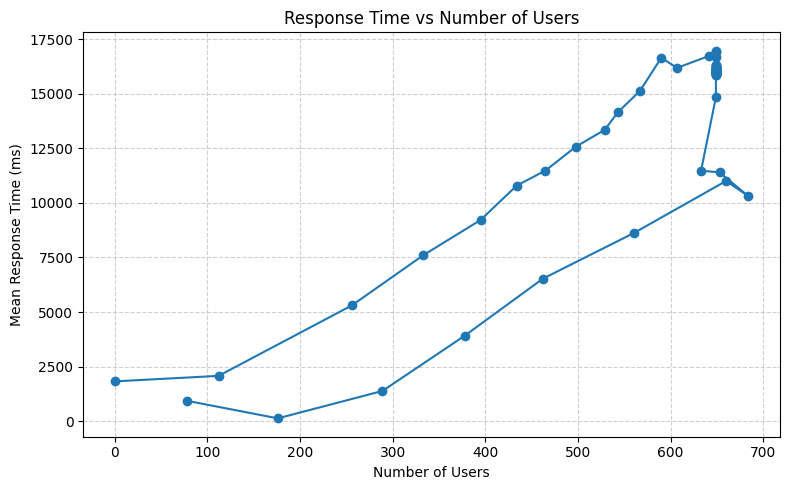

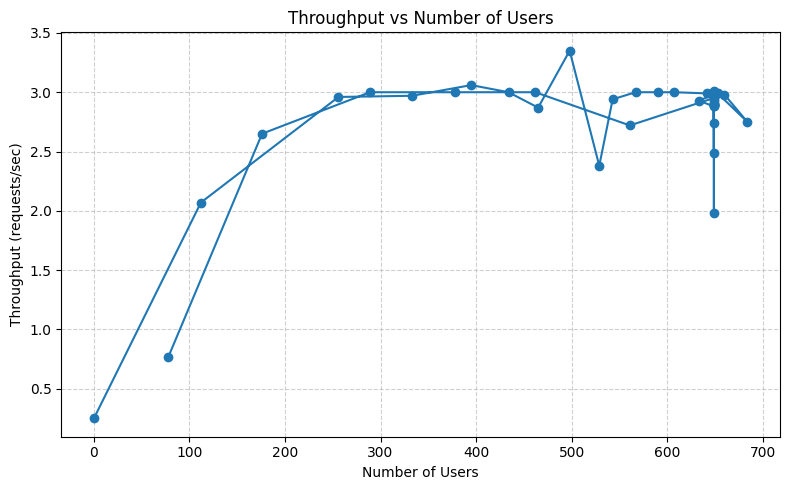

[INFO] Server CPU utilization not available in data directory.


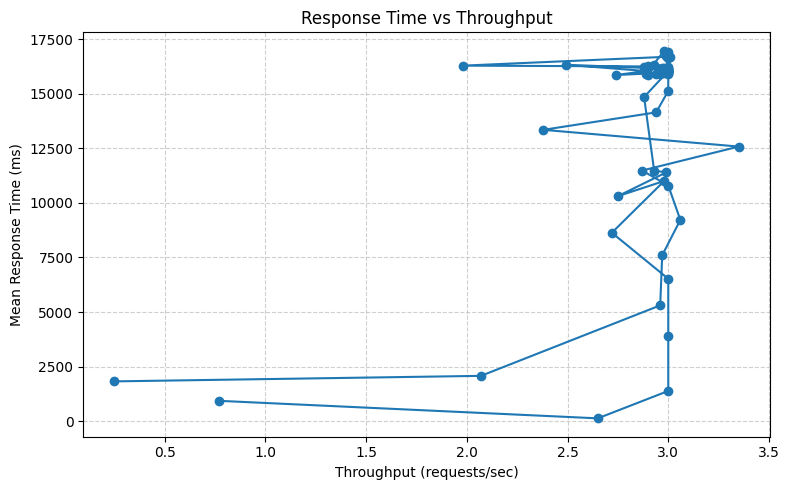

[INFO] Server utilization vs throughput cannot be plotted (no server CPU data).


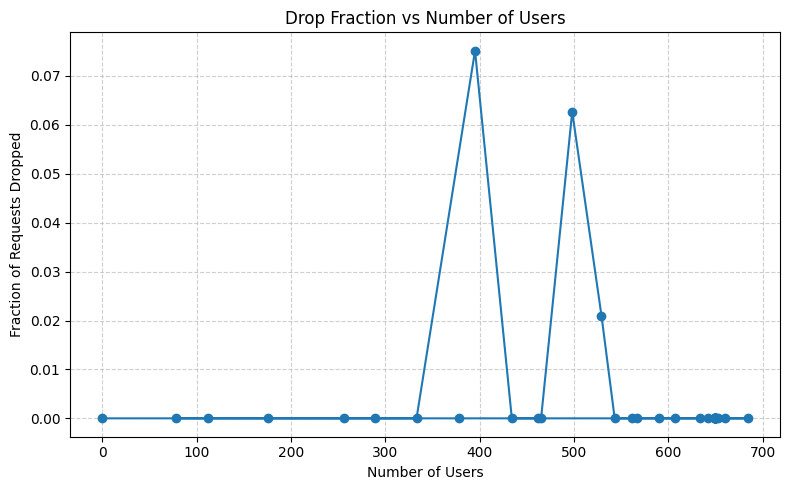

C:\Users\viren\AppData\Local\Temp\ipykernel_19156\2653620584.py:127: RuntimeWarning: divide by zero encountered in divide
  slopes = np.diff(rt) / np.diff(users)


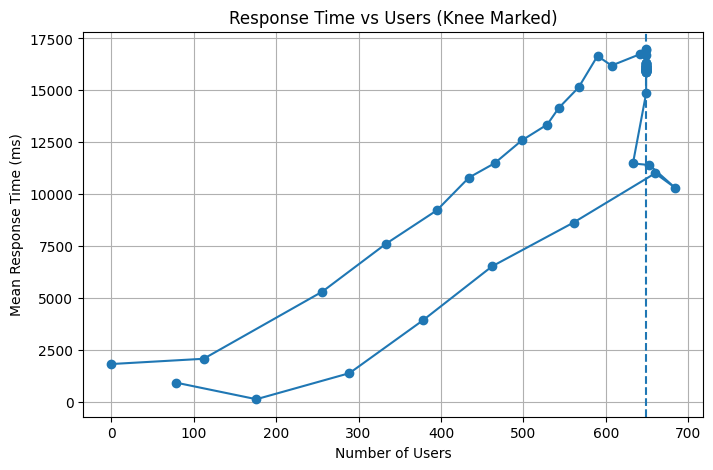

[RESULT] Approximate knee point at ~649.0 users


In [23]:
# =========================
# TSUNG DATA ANALYSIS CELL
# =========================

import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Generic loader
# -------------------------
def load_tsung_data(file_path, ncols):
    data = []
    try:
        with open(file_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= ncols:
                    data.append([float(x) for x in parts[:ncols]])
    except FileNotFoundError:
        print(f"[WARN] Missing file: {file_path}")
    return data

# -------------------------
# Extract data/*.txt stats
# -------------------------
def extract_data(data_dir="data"):
    stats = {}

    users = load_tsung_data(f"{data_dir}/users.txt", 3)
    stats["users"] = [x[1] for x in users]

    req = load_tsung_data(f"{data_dir}/request.txt", 3)
    stats["throughput"] = [x[1] for x in req]

    rt = load_tsung_data(f"{data_dir}/tr_http_request.txt", 8)
    stats["mean_rt"] = [x[2] for x in rt]

    ok = load_tsung_data(f"{data_dir}/200.txt", 3)
    stats["http_200"] = [x[1] for x in ok]

    finish = load_tsung_data(f"{data_dir}/finish_users_count.txt", 3)
    stats["finished_users"] = [x[2] for x in finish]

    return stats

# -------------------------
# Derived metrics
# -------------------------
def derive_metrics(stats):
    derived = {}
    derived["throughput_rps"] = [x / 10.0 for x in stats["throughput"]]

    derived["drop_fraction"] = [
        (t - o) / t if t > 0 else 0
        for t, o in zip(stats["throughput"], stats["http_200"])
    ]

    return derived

# -------------------------
# Plot helper
# -------------------------
def plot_curve(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(8,5))
    plt.plot(x, y, marker='o', linewidth=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# -------------------------
# MAIN EXECUTION
# -------------------------
stats = extract_data(r"D:\IITB\Courses\SEM 2\CS 681\Performance-Analysis-CS681\results\20260131-1608\data")
derived = derive_metrics(stats)

# 1. Response Time vs Users
plot_curve(
    stats["users"],
    stats["mean_rt"],
    "Number of Users",
    "Mean Response Time (ms)",
    "Response Time vs Number of Users"
)

# 2. Throughput vs Users
plot_curve(
    stats["users"],
    derived["throughput_rps"],
    "Number of Users",
    "Throughput (requests/sec)",
    "Throughput vs Number of Users"
)

# 3. CPU Utilization vs Users
# NOTE: Server CPU not available in data/*.txt
print("[INFO] Server CPU utilization not available in data directory.")

# 4. Response Time vs Throughput
plot_curve(
    derived["throughput_rps"],
    stats["mean_rt"],
    "Throughput (requests/sec)",
    "Mean Response Time (ms)",
    "Response Time vs Throughput"
)

# 5. Server Utilization vs Throughput
print("[INFO] Server utilization vs throughput cannot be plotted (no server CPU data).")

# 6. Drop Fraction vs Users
plot_curve(
    stats["users"],
    derived["drop_fraction"],
    "Number of Users",
    "Fraction of Requests Dropped",
    "Drop Fraction vs Number of Users"
)

# -------------------------
# Knee point estimation
# -------------------------
users = np.array(stats["users"])
rt = np.array(stats["mean_rt"])
slopes = np.diff(rt) / np.diff(users)
knee_idx = np.argmax(slopes)

plt.figure(figsize=(8,5))
plt.plot(users, rt, marker='o')
plt.axvline(users[knee_idx], linestyle='--')
plt.xlabel("Number of Users")
plt.ylabel("Mean Response Time (ms)")
plt.title("Response Time vs Users (Knee Marked)")
plt.grid(True)
plt.show()

print(f"[RESULT] Approximate knee point at ~{users[knee_idx]} users")


In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np

def analyze_tsung_data(data_dir, plot_dir="plots"):
    """
    Analyze Tsung data directory and generate all required plots.

    Args:
        data_dir (str): Path to Tsung data/ directory
        plot_dir (str): Directory to save plots
    """

    os.makedirs(plot_dir, exist_ok=True)

    # -------------------------
    # Generic Tsung loader
    # -------------------------
    def load_tsung_data(file_path, ncols):
        data = []
        with open(file_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= ncols:
                    data.append([float(x) for x in parts[:ncols]])
        return data

    # -------------------------
    # Extract data/*.txt
    # -------------------------
    users = load_tsung_data(f"{data_dir}/users.txt", 3)
    req = load_tsung_data(f"{data_dir}/request.txt", 3)
    rt = load_tsung_data(f"{data_dir}/tr_http_request.txt", 8)
    ok = load_tsung_data(f"{data_dir}/200.txt", 3)

    stats = {
        "users": [x[1] for x in users],
        "throughput": [x[1] for x in req],
        "mean_rt": [x[2] for x in rt],
        "http_200": [x[1] for x in ok]
    }

    # -------------------------
    # Derived metrics
    # -------------------------
    throughput_rps = [x / 10.0 for x in stats["throughput"]]
    drop_fraction = [
        (t - o) / t if t > 0 else 0
        for t, o in zip(stats["throughput"], stats["http_200"])
    ]

    # -------------------------
    # Sorted plot helper
    # -------------------------
    def plot_sorted(x, y, xlabel, ylabel, title, filename):
        pairs = sorted(zip(x, y), key=lambda p: p[0])
        x_s, y_s = zip(*pairs)

        plt.figure(figsize=(8,5))
        plt.plot(x_s, y_s, marker='o', linewidth=1.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, filename), dpi=300)
        plt.show()
        plt.close()

    # -------------------------
    # 1. Response Time vs Users
    # -------------------------
    plot_sorted(
        stats["users"], stats["mean_rt"],
        "Number of Users", "Mean Response Time (ms)",
        "Response Time vs Number of Users",
        "rt_vs_users.png"
    )

    # -------------------------
    # 2. Throughput vs Users
    # -------------------------
    plot_sorted(
        stats["users"], throughput_rps,
        "Number of Users", "Throughput (requests/sec)",
        "Throughput vs Number of Users",
        "throughput_vs_users.png"
    )

    # -------------------------
    # 3. CPU Utilization vs Users
    # -------------------------
    print("[INFO] Server CPU utilization not available in data directory.")

    # -------------------------
    # 4. Response Time vs Throughput
    # -------------------------
    plot_sorted(
        throughput_rps, stats["mean_rt"],
        "Throughput (requests/sec)", "Mean Response Time (ms)",
        "Response Time vs Throughput",
        "rt_vs_throughput.png"
    )

    # -------------------------
    # 5. Server Utilization vs Throughput
    # -------------------------
    print("[INFO] Server utilization vs throughput cannot be plotted.")

    # -------------------------
    # 6. Drop Fraction vs Users
    # -------------------------
    plot_sorted(
        stats["users"], drop_fraction,
        "Number of Users", "Fraction of Requests Dropped",
        "Drop Fraction vs Number of Users",
        "drop_fraction_vs_users.png"
    )

    # -------------------------
    # Knee point estimation
    # -------------------------
    pairs = sorted(zip(stats["users"], stats["mean_rt"]), key=lambda p: p[0])
    users_s, rt_s = zip(*pairs)

    slopes = np.diff(rt_s) / np.diff(users_s)
    knee_idx = np.argmax(slopes)

    plt.figure(figsize=(8,5))
    plt.plot(users_s, rt_s, marker='o')
    plt.axvline(users_s[knee_idx], linestyle='--')
    plt.xlabel("Number of Users")
    plt.ylabel("Mean Response Time (ms)")
    plt.title("Response Time vs Users (Knee Marked)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, "knee_point.png"), dpi=300)
    plt.show()
    plt.close()

    print(f"[RESULT] Approximate knee point at ~{users_s[knee_idx]} users")
    print(f"[INFO] Plots saved in directory: {plot_dir}")


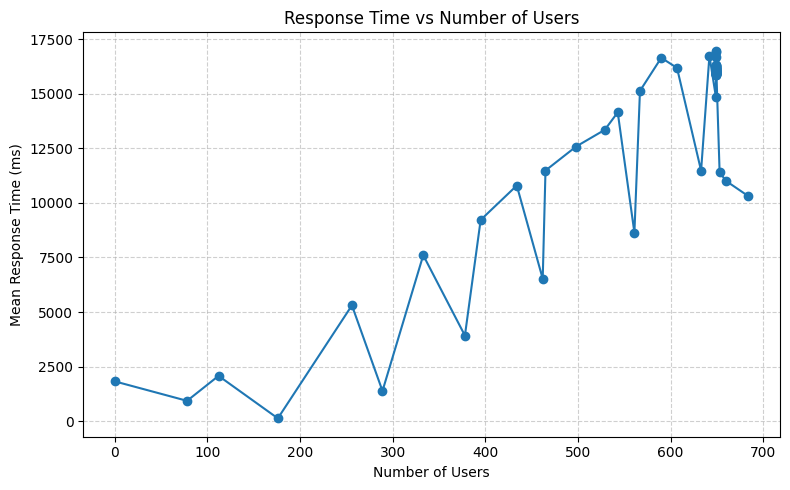

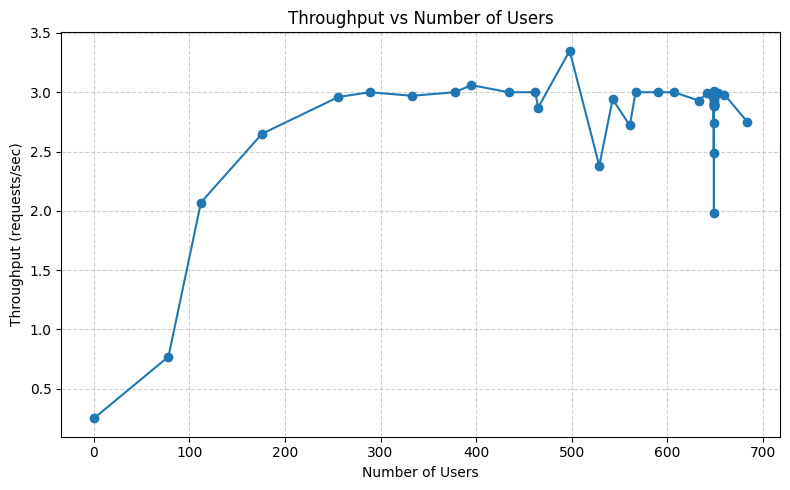

[INFO] Server CPU utilization not available in data directory.


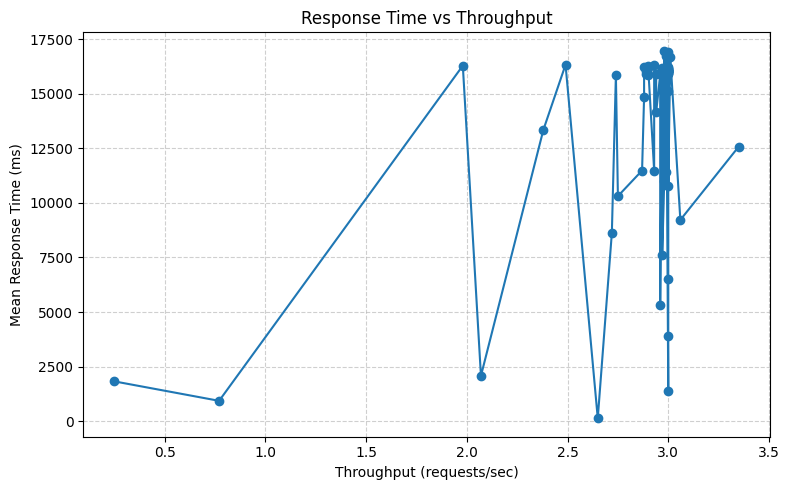

[INFO] Server utilization vs throughput cannot be plotted.


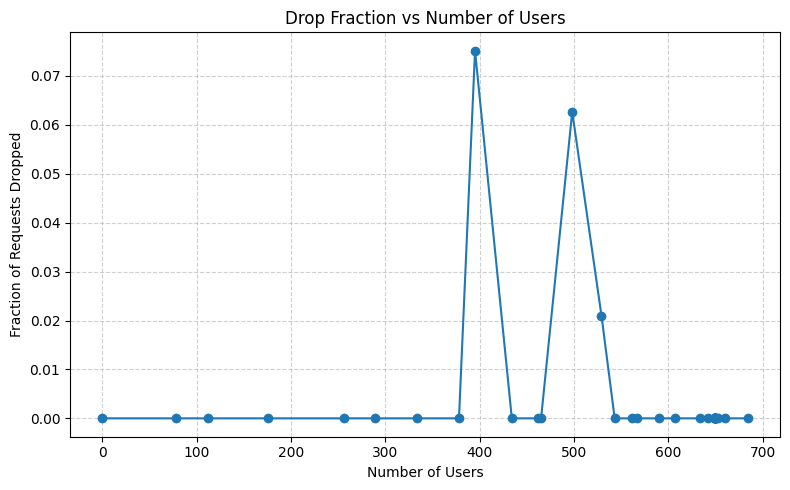

C:\Users\viren\AppData\Local\Temp\ipykernel_19156\701089111.py:126: RuntimeWarning: divide by zero encountered in divide
  slopes = np.diff(rt_s) / np.diff(users_s)


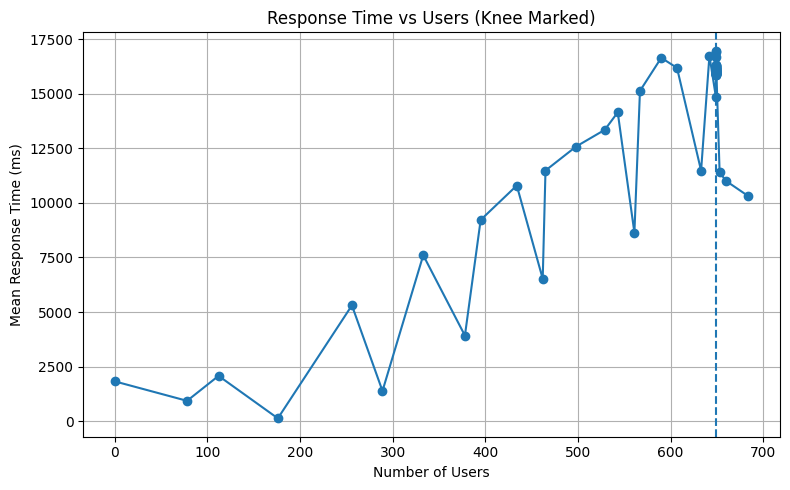

[RESULT] Approximate knee point at ~649.0 users
[INFO] Plots saved in directory: D:\IITB\Courses\SEM 2\CS 681\Performance-Analysis-CS681\visualizations\plots


In [25]:
analyze_tsung_data(r"D:\IITB\Courses\SEM 2\CS 681\Performance-Analysis-CS681\results\20260131-1608\data", r"D:\IITB\Courses\SEM 2\CS 681\Performance-Analysis-CS681\visualizations\plots")

In [1]:
def extract_rt_vs_throughput(data_dir="data", interval=10.0):
    """
    Extracts (throughput, response_time) from Tsung data files.

    Returns:
        throughput (list): requests per second
        response_time (list): mean response time in ms
    """

    throughput = []
    response_time = []

    req_file = f"{data_dir}/request.txt"
    rt_file = f"{data_dir}/tr_http_request.txt"

    with open(req_file, "r") as f_req, open(rt_file, "r") as f_rt:
        for req_line, rt_line in zip(f_req, f_rt):

            req_parts = req_line.split()
            rt_parts = rt_line.split()

            if len(req_parts) < 2 or len(rt_parts) < 3:
                continue

            # Throughput: requests/sec
            req_count = float(req_parts[1])
            throughput.append(req_count / interval)

            # Mean response time (ms)
            mean_rt = float(rt_parts[2])
            response_time.append(mean_rt)

    return throughput, response_time


In [2]:
tp, rt = extract_rt_vs_throughput(r"D:\IITB\Courses\SEM 2\CS 681\Performance-Analysis-CS681\results\20260131-1608\data")

for t, r in zip(tp[:5], rt[:5]):
    print(f"Throughput = {t:.2f} req/sec, Response Time = {r:.1f} ms")


Throughput = 0.77 req/sec, Response Time = 926.9 ms
Throughput = 2.65 req/sec, Response Time = 124.1 ms
Throughput = 3.00 req/sec, Response Time = 1379.7 ms
Throughput = 3.00 req/sec, Response Time = 3920.0 ms
Throughput = 3.00 req/sec, Response Time = 6522.9 ms


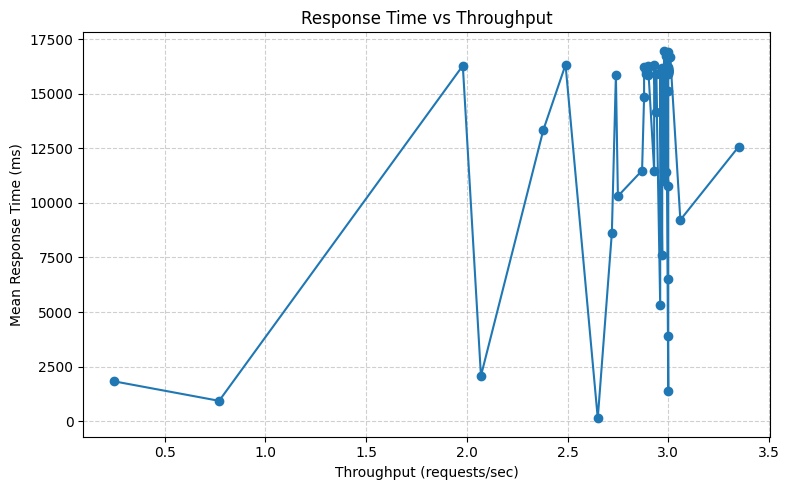

In [5]:
import matplotlib.pyplot as plt

def extract_rt_vs_throughput(data_dir="data", interval=10.0):
    throughput = []
    response_time = []

    with open(f"{data_dir}/request.txt") as f_req, \
         open(f"{data_dir}/tr_http_request.txt") as f_rt:

        for req_line, rt_line in zip(f_req, f_rt):
            req_parts = req_line.split()
            rt_parts = rt_line.split()

            if len(req_parts) < 2 or len(rt_parts) < 3:
                continue

            # Throughput (requests/sec)
            throughput.append(float(req_parts[1]) / interval)

            # Mean response time (ms)
            response_time.append(float(rt_parts[2]))

    return throughput, response_time


# -------------------------
# Extract data
# -------------------------
throughput, response_time = tp, rt

# -------------------------
# Sort by throughput (IMPORTANT)
# -------------------------
pairs = sorted(zip(throughput, response_time))
throughput_s, response_time_s = zip(*pairs)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(throughput_s, response_time_s, marker='o', linewidth=1.5)
plt.xlabel("Throughput (requests/sec)")
plt.ylabel("Mean Response Time (ms)")
plt.title("Response Time vs Throughput")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [7]:
tp

[0.77,
 2.65,
 3.0,
 3.0,
 3.0,
 2.7199999999999998,
 2.98,
 2.75,
 2.9899999999999998,
 2.93,
 2.88,
 3.0,
 3.0,
 2.9,
 2.96,
 2.98,
 3.0,
 2.94,
 2.8899999999999997,
 2.98,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.9,
 2.9699999999999998,
 2.4899999999999998,
 2.8899999999999997,
 2.7399999999999998,
 2.96,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.98,
 2.9,
 2.9699999999999998,
 3.0,
 3.0,
 2.88,
 2.93,
 3.0,
 1.98,
 3.0100000000000002,
 2.9899999999999998,
 3.0,
 3.0,
 3.0,
 2.94,
 2.38,
 3.35,
 2.87,
 3.0,
 3.06,
 2.9699999999999998,
 2.96,
 2.07,
 0.25]

In [8]:
rt

[926.9347792207794,
 124.11724150943398,
 1379.6669466666665,
 3919.9927100000027,
 6522.897116666661,
 8634.917731617648,
 11007.402835570481,
 10312.213891061443,
 11401.942276849642,
 11480.107147268402,
 14855.463103896102,
 16049.848673333336,
 15914.187636666662,
 15871.344172413805,
 15894.029817567573,
 15951.00037248322,
 15959.198829999994,
 15913.49894897959,
 15919.501294117637,
 16980.31989261746,
 16929.06059666667,
 16139.532453333335,
 15995.877436666657,
 15975.907113333342,
 16059.813926666673,
 16170.483789655178,
 16161.245303030299,
 16337.645108433737,
 16047.806394463663,
 15864.976755474447,
 15961.899814189188,
 16036.953963333332,
 16029.5615,
 16041.752229999996,
 16122.53562666667,
 16103.54343333333,
 16187.40165436241,
 16274.587862068984,
 16178.006845117836,
 16038.064153333326,
 16109.361743333331,
 16220.21020486113,
 16338.742883959036,
 16255.931780000003,
 16295.946045454546,
 16708.270611295713,
 16748.568270902993,
 16192.61050666667,
 16655.41637

In [9]:
for t, r in zip(tp[:30], rt[:30]):
    print(f"Throughput = {t:.2f} req/sec, Response Time = {r:.1f} ms")

Throughput = 0.77 req/sec, Response Time = 926.9 ms
Throughput = 2.65 req/sec, Response Time = 124.1 ms
Throughput = 3.00 req/sec, Response Time = 1379.7 ms
Throughput = 3.00 req/sec, Response Time = 3920.0 ms
Throughput = 3.00 req/sec, Response Time = 6522.9 ms
Throughput = 2.72 req/sec, Response Time = 8634.9 ms
Throughput = 2.98 req/sec, Response Time = 11007.4 ms
Throughput = 2.75 req/sec, Response Time = 10312.2 ms
Throughput = 2.99 req/sec, Response Time = 11401.9 ms
Throughput = 2.93 req/sec, Response Time = 11480.1 ms
Throughput = 2.88 req/sec, Response Time = 14855.5 ms
Throughput = 3.00 req/sec, Response Time = 16049.8 ms
Throughput = 3.00 req/sec, Response Time = 15914.2 ms
Throughput = 2.90 req/sec, Response Time = 15871.3 ms
Throughput = 2.96 req/sec, Response Time = 15894.0 ms
Throughput = 2.98 req/sec, Response Time = 15951.0 ms
Throughput = 3.00 req/sec, Response Time = 15959.2 ms
Throughput = 2.94 req/sec, Response Time = 15913.5 ms
Throughput = 2.89 req/sec, Response 